In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import yaml, cv2, random
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from ultralytics.yolo.engine.results import Results

def show_img(img, dpi=150, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, dpi=dpi)
    ax.set_title( title, fontsize=16, color='black')
    ax.axis('off')
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return fig, ax

class YOLO_dataset:
    def __init__(self, dataset_yaml:str, dataset_key:str, task="Segmentation") -> None:
        self.current = 0
        self.task = task
        
        with open(dataset_yaml) as file:
            obj = yaml.safe_load(file)

            # if "path" in obj:
            #     self.dataset_path = Path(obj["path"])
            # else:
            self.dataset_path = Path(dataset_yaml).parent

            self.img_data_dir = Path(self.dataset_path)/Path(obj[dataset_key])
            self.label_data_dir = self.img_data_dir.parent/"labels"

            self.class_num  = obj["nc"]
            self.class_name = obj["names"]

            if "nkpt" in obj:
                self.keypoint_num = obj["nkpt"]
            else:
                self.keypoint_num = None

            if "kpt_shape" in obj:
                self.kpt_shape = obj["kpt_shape"]
                self.keypoint_num = [obj["kpt_shape"][0] for _ in range(self.class_num)]
            else:
                self.kpt_shape = None

        self.img_paths   = sorted([str(path) for path in self.img_data_dir.glob("*") if path.suffix[1:] in ("jpg", "jpeg", "png")])
        self.label_paths = sorted([str(path) for path in self.label_data_dir.glob("*") if path.suffix[1:] in ("txt")])

    def __getitem__(self, key):
        data = {}

        data["img_path"] = Path(self.img_paths[key])
        data["label_path"] = Path(self.label_paths[key])
        if data["img_path"].stem != data["label_path"].stem:
            data["label_path"] = self.label_data_dir / (data["img_path"].stem + ".txt")

        img = cv2.imread(str(data["img_path"]))
        data["orig_img"] = img
        data["orig_shape"] = img.shape

        labels, bboxes, keypoints, masks = [], [], [], []
        with open(str(data["label_path"])) as f:
            annos = [l.split(" ") for l in f.read().splitlines()]
            for ann in annos:
                ann = list(map(float, ann))
                cls, center_x, center_y, width, height = ann[:5]

                w = width  * img.shape[1]
                h = height * img.shape[0]
                x1 = ((2 * center_x * img.shape[1]) - w)/2
                y1 = ((2 * center_y * img.shape[0]) - h)/2
                x2 = ((2 * center_x * img.shape[1]) + w)/2
                y2 = ((2 * center_y * img.shape[0]) + h)/2
                prob = 0
                bbox = [int(x1), int(y1), int(x2), int(y2), prob, cls]

                kp, mask = [], []
                if self.task != "Segmentation":
                    kp = ann[5:5+(self.keypoint_num[int(cls)]*3)]
                    kp = [kp[idx:idx + 3] for idx in range(0, len(kp), 3)]
                    kp = [[kp[0]*img.shape[1], kp[1]*img.shape[0], kp[2]] for kp in kp]
                else:
                    mask = ann[1:]
                    mask = [mask[idx:idx + 2] for idx in range(0, len(mask), 2)]
                    mask = [[m[0]*img.shape[1], m[1]*img.shape[0]] for m in mask]

                labels.append(str(self.class_name[int(cls)]))
                bboxes.append(bbox)

                if len(kp) > 0:
                    keypoints.append(kp)

                if len(mask) > 0:
                    masks.append(mask)

        data["labels"] = labels
        data["bboxes"] = np.array(bboxes, dtype=float)
        data["keypoints"] = np.array(keypoints, dtype=float)
        data["masks"] = np.array(masks, dtype=float)
        
        return data
        
    def __len__(self):
        return len(self.img_paths)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current == len(self):
            raise StopIteration()
        self.current += 1
        return self[self.current-1]


/home/sentan2023/anaconda3/envs/hirahara/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[41]
{0: 0, 1: 0, 2: 0, 3: 0}
yolo_datasets/nakane_grape1/train/images/00041.png
yolo_datasets/nakane_grape1/train/labels/00041.txt


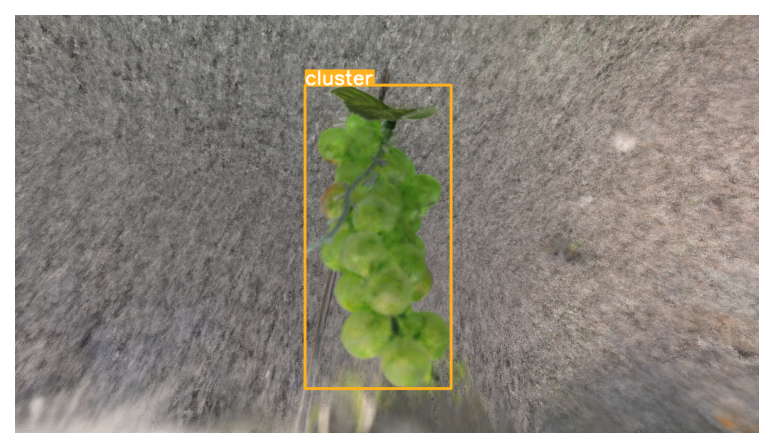

In [12]:
train_dataset = "./yolo_datasets/nakane_grape1/config.yaml"
# train_dataset = "./yolo_datasets/sentan_dataset/config.yaml"

yolo_data_train = YOLO_dataset(train_dataset, "train")
sample_index = random.sample(range(len(yolo_data_train)), 1)
print(sample_index)

print(yolo_data_train.keypoint_num)

for i in sample_index:
    yolo_data = yolo_data_train[i]
    print(yolo_data["img_path"])
    print(yolo_data["label_path"])

    res = Results(
        orig_img  = yolo_data["orig_img"],
        path      = yolo_data["img_path"],
        names     = yolo_data_train.class_name,
        boxes     = yolo_data["bboxes"],
        # masks     = yolo_data["masks"],
        # keypoints = yolo_data["keypoints"],
    )

    res_img = res.plot()
    show_img(res_img)
